### SQL-Abfragen in Relationale Algebra konvertieren

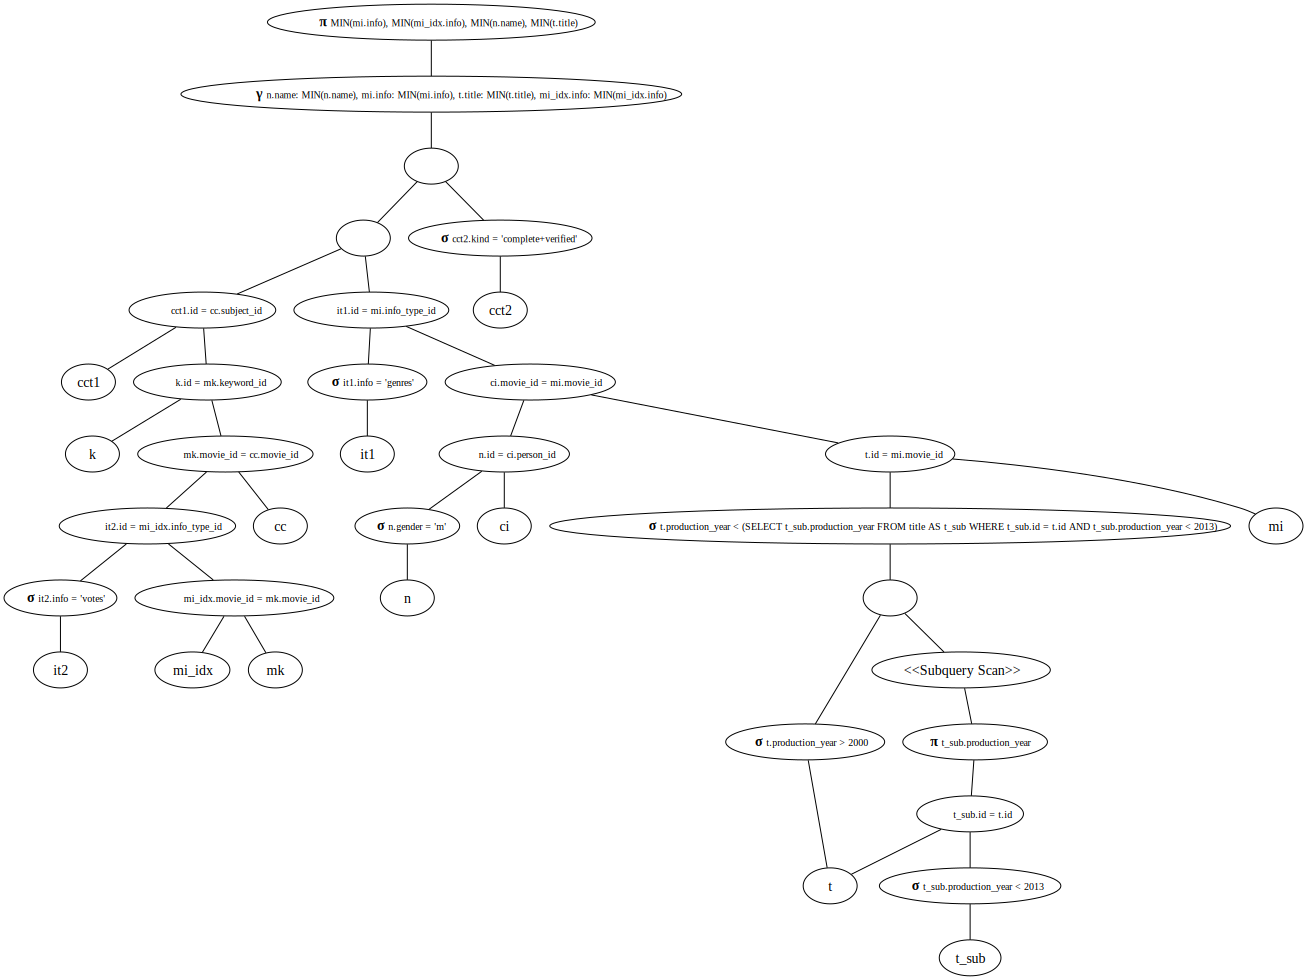

In [5]:
from postbound.vis import optimizer as opt_vis

from src.parser.parser import Parser

parser = Parser()

sql_query_1 = "select s.name,e.course from exams e, students s where s.id = e.sid and e.grade = (select min(e2.grade) from exams e2 where s.id = e2.sid);"

sql_query_2 = "select s.name, e.course from   students s, exams e where  s.id=e.sid and (s.major = 'CS' or s.major = 'Games Eng') and e.grade>=(select avg(e2.grade)+1 from exams e2 where s.id=e2.sid or (e2.curriculum=s.major and s.year>e2.date))"

sql_query_3 = "SELECT MIN(mi.info) AS movie_budget, MIN(mi_idx.info) AS movie_votes, MIN(n.name) AS writer, MIN(t.title) AS complete_violent_movie FROM complete_cast AS cc, comp_cast_type AS cct1, comp_cast_type AS cct2, cast_info AS ci, info_type AS it1, info_type AS it2, keyword AS k, movie_info AS mi, movie_info_idx AS mi_idx, movie_keyword AS mk, name AS n, title AS t WHERE  cct2.kind ='complete+verified'  AND it1.info = 'genres' AND it2.info = 'votes' AND n.gender = 'm' AND t.production_year > 2000 AND t.id = mi.movie_id AND t.id = mi_idx.movie_id AND t.id = ci.movie_id AND t.id = mk.movie_id AND t.id = cc.movie_id AND ci.movie_id = mi.movie_id AND ci.movie_id = mi_idx.movie_id AND ci.movie_id = mk.movie_id AND ci.movie_id = cc.movie_id AND mi.movie_id = mi_idx.movie_id AND mi.movie_id = mk.movie_id AND mi.movie_id = cc.movie_id AND mi_idx.movie_id = mk.movie_id AND mi_idx.movie_id = cc.movie_id AND mk.movie_id = cc.movie_id AND n.id = ci.person_id AND it1.id = mi.info_type_id AND it2.id = mi_idx.info_type_id AND k.id = mk.keyword_id AND cct1.id = cc.subject_id AND cct2.id = cc.status_id AND t.production_year > (SELECT t_sub.production_year FROM title AS t_sub WHERE t_sub.id = t.id AND t_sub.production_year < 2013)"

sql_query_4 = "SELECT MIN(mi.info) AS movie_budget, MIN(mi_idx.info) AS movie_votes, MIN(n.name) AS writer, MIN(t.title) AS complete_violent_movie FROM complete_cast AS cc, comp_cast_type AS cct1, comp_cast_type AS cct2, cast_info AS ci, info_type AS it1, info_type AS it2, keyword AS k, movie_info AS mi, movie_info_idx AS mi_idx, movie_keyword AS mk, name AS n, title AS t WHERE cct2.kind = 'complete+verified' AND it1.info = 'genres' AND it2.info = 'votes' AND n.gender = 'm' AND t.production_year > 2000 AND t.id = mi.movie_id AND ci.movie_id = mi.movie_id AND mi_idx.movie_id = mk.movie_id AND mk.movie_id = cc.movie_id AND n.id = ci.person_id AND it1.id = mi.info_type_id AND it2.id = mi_idx.info_type_id AND k.id = mk.keyword_id AND cct1.id = cc.subject_id AND t.production_year < (SELECT t_sub.production_year FROM title AS t_sub WHERE t_sub.id = t.id AND t_sub.production_year < 2013)"

sql_query_5 = "SELECT MIN(mi.info) AS movie_budget, MIN(mi_idx.info) AS movie_votes, MIN(n.name) AS writer, MIN(t.title) AS complete_violent_movie FROM complete_cast AS cc, comp_cast_type AS cct1, comp_cast_type AS cct2, cast_info AS ci, info_type AS it1, info_type AS it2, keyword AS k, movie_info AS mi, movie_info_idx AS mi_idx, movie_keyword AS mk, name AS n, title AS t WHERE cct2.kind = 'complete+verified' AND it1.info = 'genres' AND it2.info = 'votes' AND n.gender = 'm' AND ci.movie_id = mi.movie_id AND mi_idx.movie_id = mk.movie_id AND mk.movie_id = cc.movie_id AND n.id = ci.person_id AND it1.id = mi.info_type_id AND it2.id = mi_idx.info_type_id AND k.id = mk.keyword_id AND cct1.id = cc.subject_id AND t.production_year < (SELECT t_sub.production_year FROM title AS t_sub WHERE t_sub.id = t.id AND t_sub.production_year < 2013)"

relalg_query_1 = parser.parse_relalg(sql_query_1)
relalg_query_2 = parser.parse_relalg(sql_query_2)
relalg_query_3 = parser.parse_relalg(sql_query_4)
opt_vis.plot_relalg(relalg_query_3)

### Optimierung

DependentJoin
  <- Selection
    Parent: DependentJoin
    Predicate: t.production_year > 2000
    <- Relation
      Parent: Selection
  <- Projection
    Parent: DependentJoin
    <- ThetaJoin
      Parent: Projection
      Predicate: t_sub.id = t.id
      <- Relation
        Parent: ThetaJoin
      <- Selection
        Parent: ThetaJoin
        Predicate: t_sub.production_year < 2013
        <- Relation
          Parent: Selection
σ (t.production_year > 2000)
  <- t
π (t_sub.production_year)
  <- ⋈ ϴ=(t_sub.id = t.id)
    <- σ (t_sub.production_year < 2013)
      <- t_sub
    <- t
▶◁
  <- σ (t.production_year > 2000)
    <- t
  <- π (t_sub.production_year)
    <- ⋈ ϴ=(t_sub.id = t.id)
      <- DummyTable
      <- σ (t_sub.production_year < 2013)
        <- t_sub
π (MIN(mi.info), MIN(mi_idx.info), MIN(n.name), MIN(t.title))
  <- γ (n.name: MIN(n.name), mi.info: MIN(mi.info), t.title: MIN(t.title), mi_idx.info: MIN(mi_idx.info))
    <- ⨯
      <- ⨯
        <- ⋈ ϴ=(cct1.id = cc.subject_

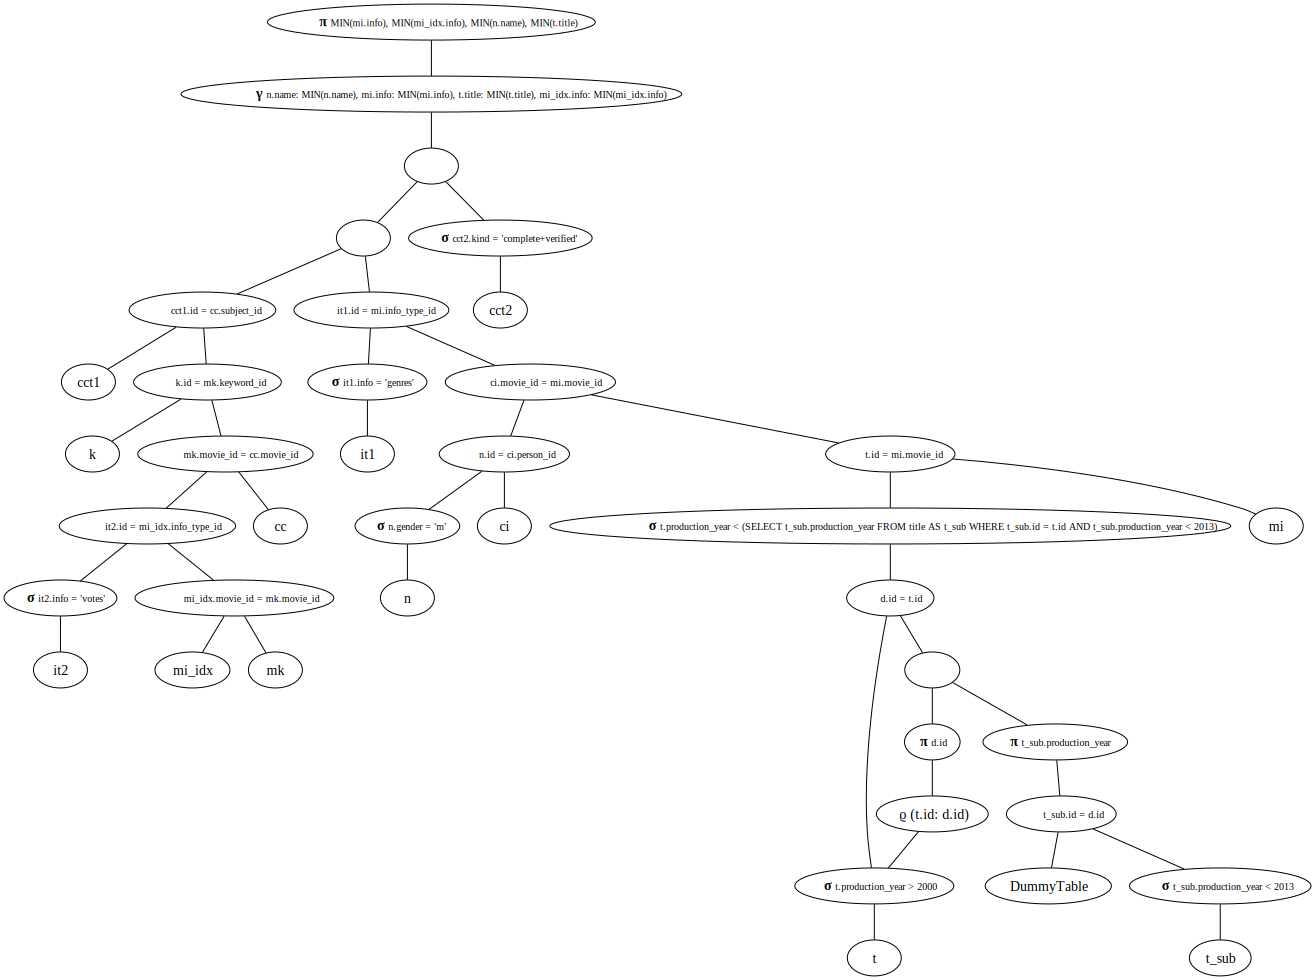

In [6]:
from src.utils.utils import Utils
from src.optimizer.push_down_manager import PushDownManager
from src.optimizer.optimizer import Optimizer

utils = Utils()
pushDownManager = PushDownManager(utils)
optimizer = Optimizer(utils)
t1, t2, dependent_join, d = optimizer.optimize_unnesting(relalg_query_3)

print(t1.inspect())
print(t2.inspect())
print(dependent_join.inspect())
print(d.inspect())

opt_vis.plot_relalg(d)


Projection
  <- GroupBy
    Parent: Projection
    <- CrossProduct
      Parent: GroupBy
      <- CrossProduct
        Parent: CrossProduct
        <- ThetaJoin
          Parent: CrossProduct
          Predicate: cct1.id = cc.subject_id
          <- Relation
            Parent: ThetaJoin
          <- ThetaJoin
            Parent: ThetaJoin
            Predicate: k.id = mk.keyword_id
            <- Relation
              Parent: ThetaJoin
            <- ThetaJoin
              Parent: ThetaJoin
              Predicate: mk.movie_id = cc.movie_id
              <- ThetaJoin
                Parent: ThetaJoin
                Predicate: it2.id = mi_idx.info_type_id
                <- Selection
                  Parent: ThetaJoin
                  Predicate: it2.info = 'votes'
                  <- Relation
                    Parent: Selection
                <- ThetaJoin
                  Parent: ThetaJoin
                  Predicate: mi_idx.movie_id = mk.movie_id
                  <- Relatio

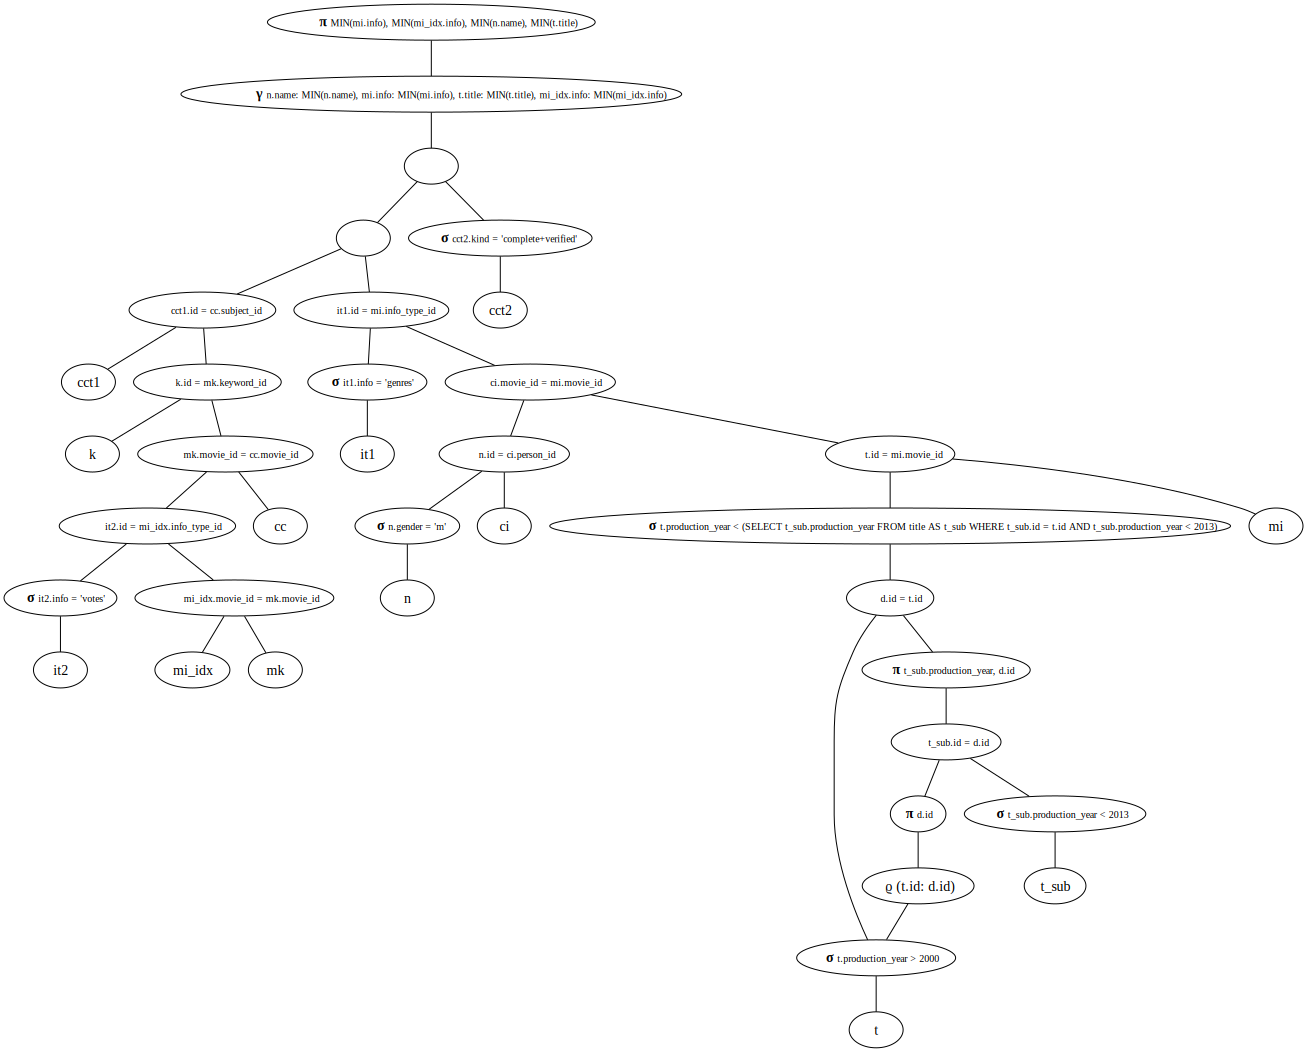

In [7]:
push_down = pushDownManager.push_down(d)
print(utils.detailed_structure_visualization(push_down))
opt_vis.plot_relalg(push_down)

In [8]:
from src.query_generator.query_generator import QueryGenerator

query_generator = QueryGenerator(utils)
print(query_generator.generate_sql_from_relalg(push_down))

StopIteration: 